In [1]:
import math
import random
from collections import defaultdict, Counter, deque
from typing import Tuple, List, Set, Dict, Counter
from typing import Any, Sequence, Mapping, Iterable, Iterator
from itertools import product, chain, islice
import doctest
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import colorama
from colorama import Fore
import numpy as np
import pylab 
import scipy.stats as stats
from scipy.stats import shapiro 
from scipy.stats import lognorm

In [2]:
#change this for different models 

maxelogain = 32
number_players =  100 #must be even
games= 100
monte_n = 100

In [3]:
class Player:
    """A player with real skill and obvservable elo.
    
    >>> Player('p1', '', '1000')  # test robustness
    Traceback (most recent call last):
        ...
    AssertionError: Must not be empty
    >>> playerA = Player('p1',1001, 1000)
    >>> playerA  # also tests __repr__()
    Player(1001, 1000)
    >>> playerA.update(10)
    >>> print(playerA)  # also tests __str__()
    (1001,1010)
    """
    def __init__(self,name:str, skill: int, elo:int) -> None:
        """Create player with given state.
        """
        assert name and skill and elo, "Must not be empty"
        self.skill: int = skill
        self.elo: int = elo
        self.name: str = name
            
    def __repr__(self) -> str:
        """Return machine-processable string representation of current state.
        """
        return f"Player({self.name},{str(self.skill)}, {str(self.elo)})"
    
    def __str__(self) -> str:
        """Return human-readable string representation of current state.
        """
        return f"({self.name},{self.skill},{self.elo})"
    
    def update(self, gain : int) -> None:
        """ Update the elo after a match"""
        self.elo = self.elo + gain


def match_chess(player1 : Player, player2: Player)->None:
    P1win = 1/(1+10**((player2.skill - player1.skill)/400))
    P1expec = 1/(1+10**((player2.elo - player1.elo)/400))
    res = random.random()
    
    if res <= P1win:
        player1.update( int(maxelogain*(1-P1expec)) ) 
        player2.update( int(maxelogain*(-1+P1expec) ))
    elif res > P1win:
        player1.update( int(maxelogain*(-P1expec) ) )
        player2.update( int(maxelogain*(P1expec )))


def ranked_elo(players2:List[Player]):
    'input a kist of players (important). Output a ranked list of players. '
    players=players2.copy()
    players.sort(key= lambda x: x.elo)
    players.reverse()
    return players

def ranked_skill(players2:List[Player]):
    'same as above, but this is real skill, baby!'
    'Every element is a rank, if multiple player have the same elo, they are in the same rank (i.e same list-element)'
    players=players2.copy()
    players.sort(key= lambda x: x.skill)
    players.reverse()
    ranks = []
    current=[]
    for p in players:
        if (len(ranks)==0 and len(current)==0):
            current += [p]
        else:
            if p.skill == current[0].skill:
                current += [p]
            else:
                ranks += [current]
                current = [p]
    if len(current)!=0:
        ranks += [current]
    return ranks


def rand_matchmaking(players:List[Player]) -> List[Player]:
    random.shuffle(players)
    return players
def chess_round_rand(players:List[Player]) -> None:
    order = rand_matchmaking(players)
    for i in range(len(players))[::2]:
        match_chess(order[i], order[i+1])
def state(players:List[Player]):
    players2 = players.copy()
    state= [[i.name,i.skill, i.elo] for i in players2]
    return state
def chess_game_rand(players:List[Player], games : int) -> List[List[Player]]:
    global Match_history 
    Match_history = [i for i in range(games+1)]
    for i in range(games):
        Match_history[i] = state(players)
        chess_round_rand(players)
    Match_history[-1] = state(players)
    return Match_history

def player_hist(player: str, match_hist):
    elos = []
    for state in match_hist:
        for p in state:
            if p[0] == player:  
                elos += [p[2]]
    return elos

def summ_i(all_the_lines: List[List[int]], x:int)->float:
    all_is = [all_the_lines[i][x] for i in range(monte_n)]
    return sum(all_is)/len(all_is)



def Sort_mcrlo(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li
def elo_matchmaking(players:List[Player]) -> List[Player]:
    players.sort(key= lambda x: x.elo)
    return players
def chess_round_elo(players:List[Player]) -> None:
    order = elo_matchmaking(players)
    for i in range(len(players))[::2]:
        match_chess(order[i], order[i+1])    
def chess_game_elo(players:List[Player], games : int) -> List[List[Player]]:
    global Match_history 
    Match_history = [i for i in range(games+1)]
    for i in range(games):
        Match_history[i] = state(players)
        chess_round_elo(players)
    Match_history[-1] = state(players)
    return Match_history

def display_ranks(players:List[Player]):
    r_skill=ranked_skill(players)
    r_elo=ranked_elo(players)
    lenskill=len(ranked_skill(players))
    
    indxplayer = 0
    r_elo_mch = []
    for r in range(lenskill):
        curr=[]
        for i in range(len(r_skill[r])):
            curr += [r_elo[indxplayer]]
            indxplayer += 1
        r_elo_mch += [curr]
    r_elo = r_elo_mch
    
    for i in range(lenskill):
        if r_skill[i] == r_elo[i]: 
            print(Fore.GREEN + str(i+1)+'::',  str([p.name for p in r_skill[i]])+' vs ',   str([p.name for p in r_elo[i]]))
        elif r_skill[i] != r_elo[i]:
            print(Fore.RED + str(i+1)+'::',  str([p.name for p in r_skill[i]]) +' vs ',   str([p.name for p in r_elo[i]]))   
    
def display_ranks_monte(players:List[Player], montec:List[List[int]])-> List[int]:
    
    final_score_mcrlo.sort(key = lambda x: x[1])
    final_score_mcrlo.reverse()
    r_elo = final_score_mcrlo
    
    r_skill=ranked_skill(players)
    lenskill=len(ranked_skill(players))
    
    indxplayer = 0
    r_elo_mch = []
    for r in range(lenskill):
        curr=[]
        for i in range(len(r_skill[r])):
            curr += [r_elo[indxplayer]]
            indxplayer += 1
        r_elo_mch += [curr]
    r_elo = r_elo_mch
    position_score = []
    
    for i in range(lenskill):
        r_names_sk = [r_skill[i][x].name for x in range(len(r_skill[i]))]
        r_names_el = [r_elo[i][x][0] for x in range(len(r_elo[i]))]
        if r_names_sk == r_names_el: 
            position_score += [1]
            print(Fore.GREEN + str(i+1)+'::',  str(r_names_sk)+' vs ',   str(r_names_el))
        elif  r_names_sk != r_names_el:
            position_score += [0]
            print(Fore.RED + str(i+1)+'::', str(r_names_sk)+' vs ',   str(r_names_el))  
    return position_score

In [4]:
#doctest.run_docstring_examples(Player, globals(), verbose=True, name="Player")

In [5]:
player_names = ['p'+str(i) for i in range(1,number_players+1)]
player_skills = [ random.randint(1,2800) for i in range(1,number_players+1)]

players = [Player(player_names[i],  player_skills[i], 1000) for i in range(number_players)]

In [6]:
'''
player_names = ['p'+str(i) for i in range(1,number_players+1)]
player_skills = [ (2000/number_players)*i for i in range(1,number_players+1)]
players = [Player(player_names[i],  player_skills[i], 1000) for i in range(number_players)]
'''

"\nplayer_names = ['p'+str(i) for i in range(1,number_players+1)]\nplayer_skills = [ (2000/number_players)*i for i in range(1,number_players+1)]\nplayers = [Player(player_names[i],  player_skills[i], 1000) for i in range(number_players)]\n"

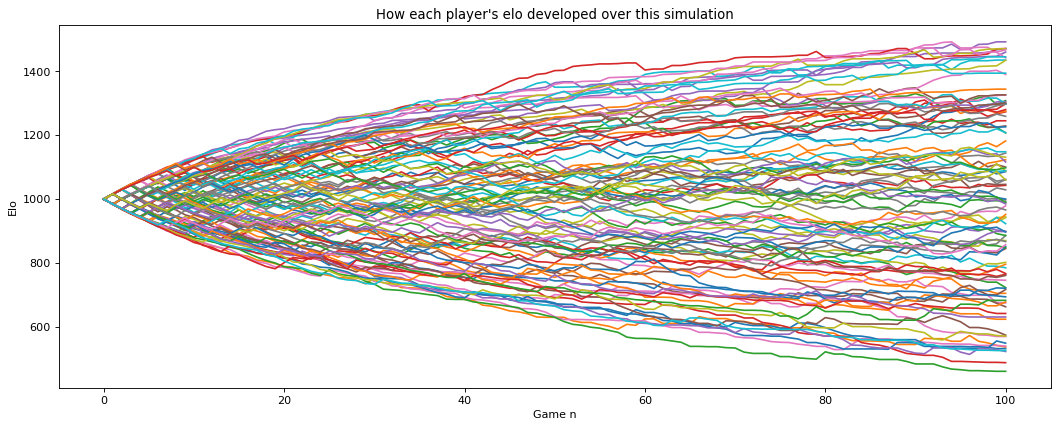

In [7]:
#The graph of how each player's elo developed over the 100 games
chess_game_rand(players, games) 
x = range(games+1)     #+5
all_the_ys = [player_hist('p'+str(i),Match_history) for i in range(1,number_players+1)]
figure(figsize=(16, 6), dpi=80)

for i in range(len(all_the_ys)):   
    plt.plot(x, all_the_ys[i], label = "Player "+str(i+1))    #+5*[all_the_ys[i][-1]
    

plt.xlabel('Game n') 
plt.ylabel('Elo') 
plt.title("How each player's elo developed over this simulation")
plt.savefig('single_rand_elosgraph.png')
plt.show()

In [8]:
#How does the elo ranking compare to the real skill ranking?
display_ranks(players)

1:: ['p77'] vs  ['p5']
2:: ['p5'] vs  ['p64']
3:: ['p69'] vs  ['p15']
4:: ['p64'] vs  ['p69']
5:: ['p25'] vs  ['p77']
6:: ['p47'] vs  ['p25']
7:: ['p80'] vs  ['p80']
8:: ['p20'] vs  ['p47']
9:: ['p90'] vs  ['p20']
10:: ['p67'] vs  ['p39']
11:: ['p39'] vs  ['p90']
12:: ['p15'] vs  ['p87']
13:: ['p92'] vs  ['p92']
14:: ['p86'] vs  ['p67']
15:: ['p13'] vs  ['p86']
16:: ['p87'] vs  ['p13']
17:: ['p55'] vs  ['p55']
18:: ['p96'] vs  ['p96']
19:: ['p58'] vs  ['p60']
20:: ['p60'] vs  ['p44']
21:: ['p94'] vs  ['p11']
22:: ['p34'] vs  ['p58']
23:: ['p42'] vs  ['p94']
24:: ['p26'] vs  ['p42']
25:: ['p88'] vs  ['p34']
26:: ['p44'] vs  ['p88']
27:: ['p11'] vs  ['p4']
28:: ['p23'] vs  ['p26']
29:: ['p4'] vs  ['p91']
30:: ['p91'] vs  ['p40']
31:: ['p40'] vs  ['p23']
32:: ['p89'] vs  ['p22']
33:: ['p50'] vs  ['p50']
34:: ['p28'] vs  ['p28']
35:: ['p22'] vs  ['p89']
36:: ['p35'] vs  ['p32']
37:: ['p33'] vs  ['p35']
38:: ['p32'] vs  ['p6']
39:: ['p30'] vs  ['p33']
40:: ['p29'] vs  ['p30']
41:: ['p1'] vs

In [9]:
#for montecarlo sim, we use the same players and run a bunch (100) of simulations of games
Lotta_games_rand = []

for i in range(monte_n):
    players = [Player(player_names[i],  player_skills[i], 1000) for i in range(number_players)]
    Lotta_games_rand += [chess_game_rand(players, games)]

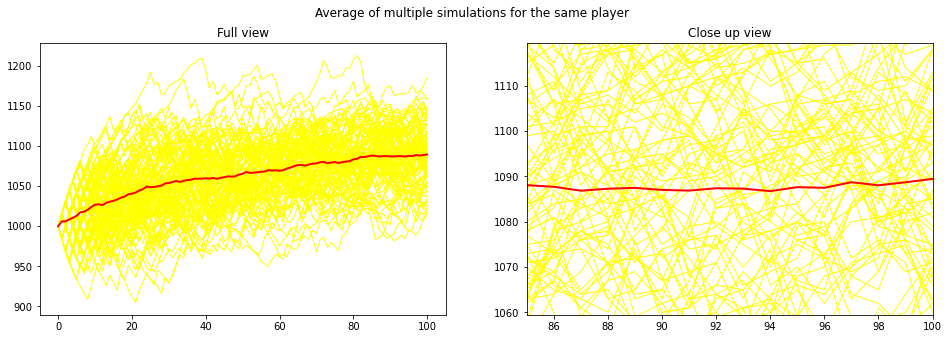

In [10]:
#For a single player , this is 100 simulations of how their 100 games (x axis) could have gone, we will average
#to find how well they're expected to do:

player_n = 1 #what player do we want to look at

x = range(games+1)  
all_the_lines = [player_hist('p'+str(player_n),Lotta_games_rand[i]) for i in range(monte_n)]

fig, axx = plt.subplots(figsize=(16, 5))
ax = plt.subplot(121)
ax2 = plt.subplot(122)
fig.suptitle('Average of multiple simulations for the same player')
ax.set_title('Full view')
ax2.set_title('Close up view')
for i in range(len(all_the_lines)):
    ax.plot(x, all_the_lines[i],linewidth=1, color='yellow') 
    ax2.plot(x, all_the_lines[i],linewidth=1, color='yellow') 
    
final= [summ_i(all_the_lines, x) for x in range(games+1)]
ax.plot(x, final , label = "Player "+str(player_n), color='red', linewidth=2 )
ax2.plot(x, final , label = "Player "+str(player_n), color='red', linewidth=2 )


ax2.set_xlim([games -15,games])
ax2.set_ylim([final[-1]-30, final[-1]+30])
#plt.legend()
fig.savefig('Single player montecarlo.png')
plt.show()

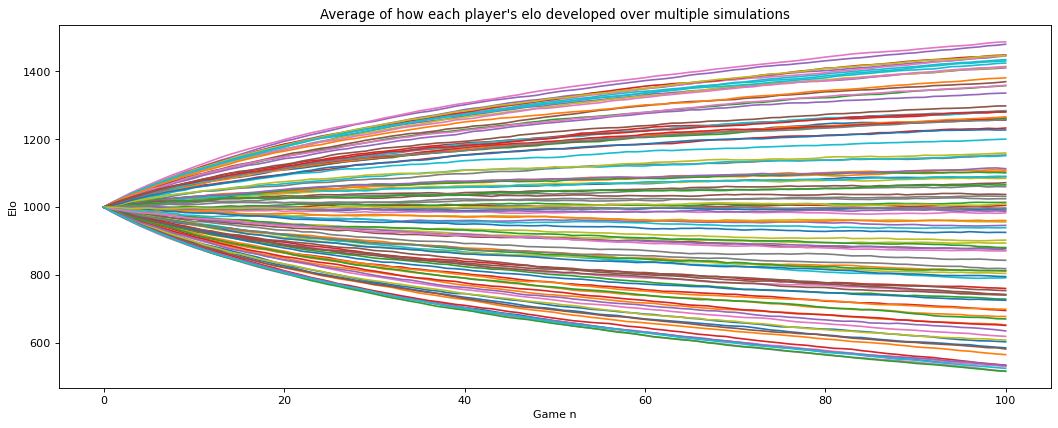

In [11]:
#we can now graph all players after doing montecarlo

x = range(games+1) 
figure(figsize=(16, 6), dpi=80) 

final_score_mcrlo=[]

for playerr in range(1, number_players+1):
    player_n = playerr #what player do we want to look at
    all_the_lines = [player_hist('p'+str(player_n),Lotta_games_rand[i]) for i in range(monte_n)]
    y_avg = [summ_i(all_the_lines, x) for x in range(games+1)]
    final_score_mcrlo += [['p'+str(playerr), y_avg[-1]]]
    plt.plot(x,y_avg , label = "Player "+str(player_n) )

plt.title("Average of how each player's elo developed over multiple simulations")
plt.xlabel('Game n') 
plt.ylabel('Elo') 
plt.savefig('Monte_rand')
#plt.legend()
plt.show()

In [12]:
#real rankings vs expected (average) rankings of players:

score_rand = display_ranks_monte(players,final_score_mcrlo )
print(np.dot(score_rand, score_rand)/number_players)

1:: ['p77'] vs  ['p77']
2:: ['p5'] vs  ['p5']
3:: ['p69'] vs  ['p64']
4:: ['p64'] vs  ['p47']
5:: ['p25'] vs  ['p69']
6:: ['p47'] vs  ['p25']
7:: ['p80'] vs  ['p20']
8:: ['p20'] vs  ['p80']
9:: ['p90'] vs  ['p90']
10:: ['p67'] vs  ['p67']
11:: ['p39'] vs  ['p39']
12:: ['p15'] vs  ['p15']
13:: ['p92'] vs  ['p92']
14:: ['p86'] vs  ['p86']
15:: ['p13'] vs  ['p87']
16:: ['p87'] vs  ['p13']
17:: ['p55'] vs  ['p55']
18:: ['p96'] vs  ['p96']
19:: ['p58'] vs  ['p58']
20:: ['p60'] vs  ['p60']
21:: ['p94'] vs  ['p94']
22:: ['p34'] vs  ['p34']
23:: ['p42'] vs  ['p42']
24:: ['p26'] vs  ['p23']
25:: ['p88'] vs  ['p11']
26:: ['p44'] vs  ['p26']
27:: ['p11'] vs  ['p88']
28:: ['p23'] vs  ['p44']
29:: ['p4'] vs  ['p4']
30:: ['p91'] vs  ['p91']
31:: ['p40'] vs  ['p40']
32:: ['p89'] vs  ['p89']
33:: ['p50'] vs  ['p28']
34:: ['p28'] vs  ['p50']
35:: ['p22'] vs  ['p35']
36:: ['p35'] vs  ['p22']
37:: ['p33'] vs  ['p32']
38:: ['p32'] vs  ['p33']
39:: ['p30'] vs  ['p30']
40:: ['p29'] vs  ['p1']
41:: ['p1'] vs

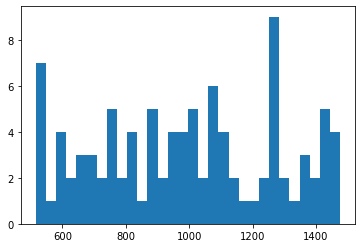

In [13]:
#Question: Do our players get distributed normally based on elo with random?
dist_rand =np.array([int(i[1]) for i in final_score_mcrlo])
bins=math.ceil(math.sqrt((max(dist_rand)-min(dist_rand))))
plt.hist(dist_rand ,bins=[i for i in range(min(dist_rand),max(dist_rand))][::bins])
plt.savefig('distr_rand.png')

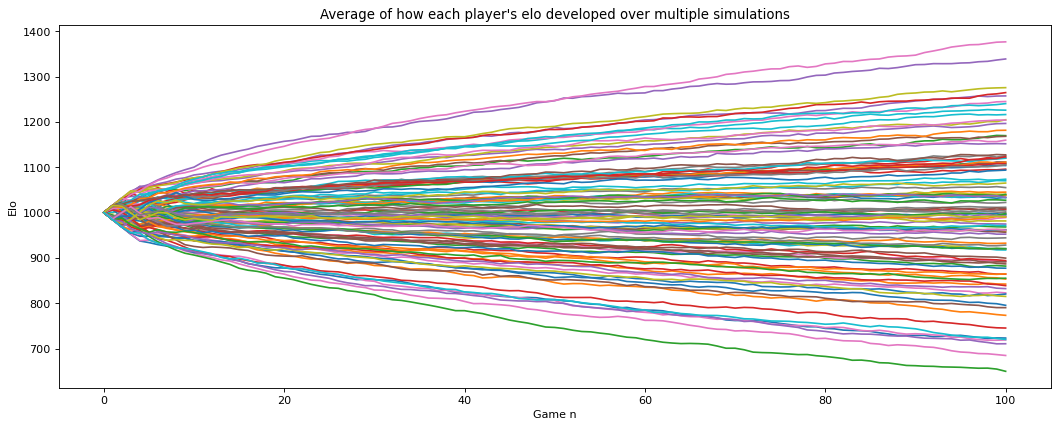

In [22]:
Lotta_games_elo = []

for i in range(monte_n):
    players = [Player(player_names[i],  player_skills[i], 1000) for i in range(number_players)]
    Lotta_games_elo += [chess_game_elo(players, games)]

    
#we can now graph all players after doing montecarlo

x = range(games+1) 
figure(figsize=(16, 6), dpi=80) 

final_score_mcrlo2=[]

for playerr in range(1, number_players+1):
    player_n = playerr #what player do we want to look at
    all_the_lines = [player_hist('p'+str(player_n),Lotta_games_elo[i]) for i in range(monte_n)]
    y_avgi = [summ_i(all_the_lines, x) for x in range(games+1)]
    final_score_mcrlo2 += [['p'+str(playerr), y_avgi[-1]]]
    plt.plot(x,y_avgi , label = "Player "+str(player_n) )

plt.title("Average of how each player's elo developed over multiple simulations")
plt.xlabel('Game n') 
plt.ylabel('Elo') 
plt.savefig('Monte_elo')
#plt.legend()
plt.show()

In [15]:
#real rankings vs expected (average) rankings of players:

score_elo = display_ranks_monte(players,final_score_mcrlo2 )

1:: ['p77'] vs  ['p77']
2:: ['p5'] vs  ['p5']
3:: ['p69'] vs  ['p64']
4:: ['p64'] vs  ['p47']
5:: ['p25'] vs  ['p69']
6:: ['p47'] vs  ['p25']
7:: ['p80'] vs  ['p20']
8:: ['p20'] vs  ['p80']
9:: ['p90'] vs  ['p90']
10:: ['p67'] vs  ['p67']
11:: ['p39'] vs  ['p39']
12:: ['p15'] vs  ['p15']
13:: ['p92'] vs  ['p92']
14:: ['p86'] vs  ['p86']
15:: ['p13'] vs  ['p87']
16:: ['p87'] vs  ['p13']
17:: ['p55'] vs  ['p55']
18:: ['p96'] vs  ['p96']
19:: ['p58'] vs  ['p58']
20:: ['p60'] vs  ['p60']
21:: ['p94'] vs  ['p94']
22:: ['p34'] vs  ['p34']
23:: ['p42'] vs  ['p42']
24:: ['p26'] vs  ['p23']
25:: ['p88'] vs  ['p11']
26:: ['p44'] vs  ['p26']
27:: ['p11'] vs  ['p88']
28:: ['p23'] vs  ['p44']
29:: ['p4'] vs  ['p4']
30:: ['p91'] vs  ['p91']
31:: ['p40'] vs  ['p40']
32:: ['p89'] vs  ['p89']
33:: ['p50'] vs  ['p28']
34:: ['p28'] vs  ['p50']
35:: ['p22'] vs  ['p35']
36:: ['p35'] vs  ['p22']
37:: ['p33'] vs  ['p32']
38:: ['p32'] vs  ['p33']
39:: ['p30'] vs  ['p30']
40:: ['p29'] vs  ['p1']
41:: ['p1'] vs

In [16]:
print(np.dot(score_elo,score_elo)/number_players)

0.6


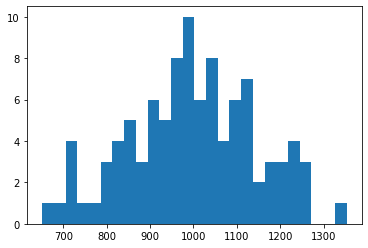

In [17]:
#Question: Do our players get distributed normally based on elo?
a=np.array([int(i[1]) for i in final_score_mcrlo2])
bins=math.ceil(math.sqrt((max(a)-min(a))))

plt.hist(a,bins=[i for i in range(min(a),max(a))][::bins])
#plt.savefig('Normal_matchmaking_400p.png')
plt.show()

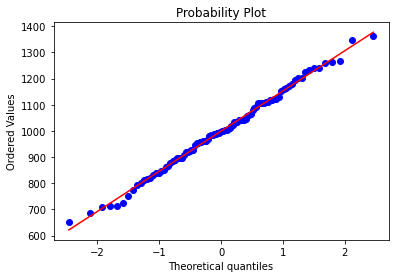

999.53 22723.6091


In [18]:
#Is this dist. normal? Yes!
stats.probplot(a, dist="norm", plot=pylab)
#plt.savefig('qq-plot_normal_400p.png')
pylab.show()
shapiro(a)

Mean_a = sum(a)/len(a)
var_a= np.var(a)
print(Mean_a, var_a)

In [19]:
shapiro(a)

ShapiroResult(statistic=0.9931827187538147, pvalue=0.8988339304924011)

In [20]:
print(Mean_a, var_a)

999.53 22723.6091


In [21]:
'''
maxelogain = 32
number_players =  200 #must be even
games= 500
monte_n = 100
vars = []
for i in range(1,10):
    player_names = ['p'+str(i) for i in range(1,number_players+1)]
    player_skills = [ random.randint(1,2800) for i in range(1,number_players+1)]
    mean_skills =  sum(player_skills)/number_players
    var_skills = np.var(player_skills)
    players = [Player(player_names[i],  player_skills[i], 1000) for i in range(number_players)]

    Lotta_games_elo = []

    for i in range(monte_n):
        players = [Player(player_names[i],  player_skills[i], 1000) for i in range(number_players)]
        Lotta_games_elo += [chess_game_elo(players, games)]


    #we can now graph all players after doing montecarlo

    x = range(games+1) 
    #figure(figsize=(16, 6), dpi=80) 

    final_score_mcrlo2=[]

    for playerr in range(1, number_players+1):
        player_n = playerr #what player do we want to look at
        all_the_lines = [player_hist('p'+str(player_n),Lotta_games_elo[i]) for i in range(monte_n)]
        y_avgi = [summ_i(all_the_lines, x) for x in range(games+1)]
        final_score_mcrlo2 += [['p'+str(playerr), y_avgi[-1]]]
        #plt.plot(x,y_avgi , label = "Player "+str(player_n) )


    #plt.legend()
    #plt.show()

    a=np.array([int(i[1]) for i in final_score_mcrlo2])

    Mean_a = sum(a)/len(a)
    var_a= np.var(a)
    print('mean el: ' + str(Mean_a) + ' var el: ' + str(var_a) + ' | mean sk: ' +  str(mean_skills) + ' var sk: ' + str(var_skills))
    vars+=[var_a]
print(sum(vars)/len(vars))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-21-23502b33aee3>, line 45)